# Fun with Newick Data

In [1]:
import io
import pandas as pd
from Bio import Phylo

### 1. Lets take a look at the intMemoir dataset:

In [52]:
pd.read_csv('Dream_data_intMemoir.csv', sep = '\t').head()

,fileNumber,fileName,dreamID,nCells,ground,rec
0,2,s1_c2_data,1,4,"((1_2012210001:29,2_2012210001:29):51,(3_22122...","(((1_2012210001:0.2845811716,2_2012210001:0.28..."
1,4,s10_c2_data,2,19,"(((((1_1111211121:5,2_1111211121:5):47,(3_1112...","((((5_0110212021:28.57142857,6_0110212021:28.5..."
2,5,s10_c3_data,3,20,"(((((1_2112211021:18,2_2112211021:18):44,(3_21...","(((23_2112210021:80,(8_2112211021:70,(7_211221..."
3,8,s11_c1_data,4,6,"((1_2202210001:61,2_2202000001:61):124,((3_222...","(((1_2202210001:0.4059306243,2_2202000001:0.40..."
4,10,s12_c2_data,5,4,"((1_2102111000:15,2_2100111000:15):52,(3_21001...","(1_2102111000:0.5032868538,(2_2100111000:0.393..."


This is a 106x6 DataFrame, with the following columns:  
**fileName**: File source.  
**dreamID**: The number of the entry represents the ID of that tree and should match other files.  
**nCells**: The number of cells that survived for the whole experiment and hence have readout i.e. The number of leaves in the tree.  
**ground**: The actual tree, this is the ground truth validated using a time-lapse of the growing colony of cells and is manually curated. The ground truth lineage tree is provided as a Newick File. The cell ID links the barcode to the Newick file.  
**rec** The reconstructed lineage using the sister-likelihood method. Newick format.


### 2. Parsing out what we need:  
Let's define some functions/classes to extract what we actually need for our alignment problem.

In [53]:
def Barcode_Dict(tree):
    '''given a tree in Newick format, returns dictionary of type cell:barcode'''
    barcode_dict = dict()
    tree_nodes = Phylo.read(io.StringIO(tree), 'newick').get_terminals()
    for i in range(len(tree_nodes)):
        name_code = tree_nodes[i].name.split('_')
        barcode_dict[name_code[0]] = name_code[1]
    
    return barcode_dict

def Barcode_DF(data):
    '''returns DataFrame of dreamID: barcode dictionary'''
    name_code_frame = data[['dreamID','ground']]
    name_code_frame.iloc[:,1] = name_code_frame['ground'].apply(Barcode_Dict)
    name_code_frame = name_code_frame.rename(
            columns = {'dreamID':'dreamID', 'ground': 'CellBarcodes'}
        )
        
    return name_code_frame

def Barcode_Lists(bc_df):
    '''Given a Barcode_DF product, return list of lists'''
    cellBarcodes = bc_df['CellBarcodes'].to_list()
    bc_list = []
    for i in range(len(cellBarcodes)):
        bc_list.append(list(cellBarcodes[i].values()))
    return bc_list
    
class Cell_Data:
    
    def __init__(self, file_name):
        
        data = pd.read_csv(file_name, sep = '\t')
        train_set = data[30:]
        test_set = data[:30]
        self.train = Barcode_DF(train_set) #76x2 DF
        self.true_train = train_set[['dreamID','ground']]
        self.true_test = test_set[['dreamID','ground']]
        self.test = Barcode_DF(test_set) #30x2 DF
        
    def Train(self):
        return Barcode_Lists(self.train)
    def Test(self):
        return Barcode_Lists(self.test)
    
    def get_ground(self, code_list):
        '''Given a list of cells from Train/Test methods, return Newick formatted Lineage'''
        in_train = True
        mask = [code_list == list(some_dict.values()) for some_dict in self.train['CellBarcodes']]
        if mask.count(True) == 0:
            mask = [code_list == list(some_dict.values()) for some_dict in self.test['CellBarcodes']]
            in_train = False
        if in_train:
            return self.true_train[mask]['ground'].item()
        else:
            return self.true_test[mask]['ground'].item()
        
    def get_id(self, code_list):
        '''Given a list of cells from Train/Test methods, return dreamID'''
        in_train = True
        mask = [code_list == list(some_dict.values()) for some_dict in self.train['CellBarcodes']]
        if mask.count(True) == 0:
            mask = [code_list == list(some_dict.values()) for some_dict in self.test['CellBarcodes']]
            in_train = False
        if in_train:
            return self.true_train[mask]['dreamID'].item()
        else:
            return self.true_test[mask]['dreamID'].item()
        
cell_data = Cell_Data('Dream_data_intMemoir.csv')

In [70]:
#using this class:
train_case = cell_data.Train()[0]
test_case = cell_data.Test()[0]
print('Example of Cell:Barcode set as defined by the DREAM challenge:')
print(cell_data.train['CellBarcodes'][30])
print()
print('List of barcodes in a given set:')
print(train_case)
print()
print('Newick format for above case:')
print(cell_data.get_ground(test))

Example of Cell:Barcode set as defined by the DREAM challenge:
{'1': '2012212021', '2': '2112212021', '3': '2112212021', '4': '2112212021', '5': '0012212221', '6': '0012012221', '8': '2120010021', '9': '2120010021', '10': '0112212221'}

List of barcodes in a given set:
['2012212021', '2112212021', '2112212021', '2112212021', '0012212221', '0012012221', '2120010021', '2120010021', '0112212221']

Newick format for above case:
((((1_2012212021:8,2_2112212021:8):38,(3_2112212021:4,4_2112212021:4):42):42,(5_0012212221:1,6_0012012221:1):87):46,((8_2120010021:22,9_2120010021:22):51,10_0112212221:74):62);


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: `item` has been deprecated and will be removed in a future version


### 3. Visualizing Newick-formatted Trees

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: `item` has been deprecated and will be removed in a future version


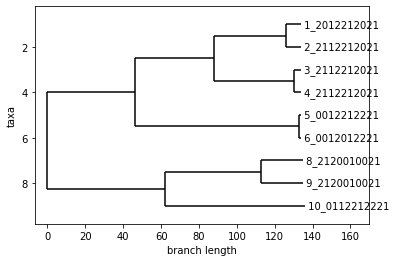

None


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: `item` has been deprecated and will be removed in a future version


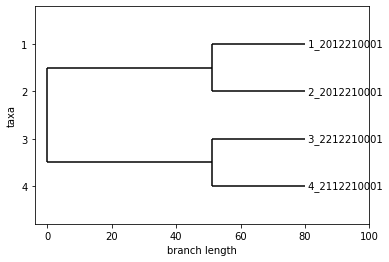

None


In [55]:
def showTree(tree):
    '''Given string of Newick fromat, draw tree'''
    instance = Phylo.read(io.StringIO(tree), 'newick')
    print(Phylo.draw(instance))

showTree(cell_data.get_ground(train_case))
showTree(cell_data.get_ground(test_case))